<a href="https://colab.research.google.com/github/11uc/nhl-prediction-notebooks/blob/main/points_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

In [2]:
!pip install tensorflow_addons

In [3]:
import tensorflow_addons as tfa

## Load data

### Team roster

In [4]:
players = pd.read_csv("players.csv", dtype = {"season": str})

### Player stats

In [5]:
player_stats = pd.read_csv("player_stats.csv", dtype = {"season": str})

### Team seasonal stats

In [6]:
# Load from drive
team_seasonal = pd.read_csv("team_seasonal.csv",
                            dtype = {"season": str})

In [7]:
# Normalize these by game numbers
toDiv = ["wins", "losses", "ot", "pts",
         "powerPlayGoals", "powerPlayGoalsAgainst",
         "powerPlayOpportunities", "faceOffsTaken"]
# These need to be converted to floats
pctCols = ["powerPlayPercentage",
           "penaltyKillPercentage",
           "faceOffWinPercentage"]
# Redundant
toDrop = ["ptPctg", "faceOffsWon", "faceOffsLost"]

In [8]:
team_seasonal_norm = team_seasonal.drop(toDrop, 1)
team_seasonal_norm[toDiv] = \
    team_seasonal[toDiv].divide(team_seasonal["gamesPlayed"], 
                                axis = 0)
team_seasonal_norm[pctCols] = \
    team_seasonal[pctCols].astype("float")

### Player seasonal data
* If a player is in multiple teams for a season,
used the combined stats.
* Add games played over team total games as 
a feature.

In [9]:
def strToSeconds(t):
    if pd.isna(t):
        return None
    min, sec = t.split(':')
    return int(min) * 60 + int(sec)

#### Skaters

In [10]:
skater_seasonal = pd.read_csv("skater_uni.csv",
                              dtype = {"season": str})

In [11]:
# Convert time data to seconds
timeCols = ["timeOnIce", "powerPlayTimeOnIce", 
            "evenTimeOnIce", "shortHandedTimeOnIce"]
# Drop penaltyMinutes, same as pim
toDrop = ["penaltyMinutes"]
# Normalize most features by dividing with game numbers
notToDiv = ["games", "shotPct", "plusMinus", "season",
            "playerId", "faceOffPct", "penaltyMinutes"]
toDiv = list(set(skater_seasonal.columns) - set(notToDiv))

In [12]:
skater_norm = skater_seasonal.drop(columns = toDrop)
skater_norm[timeCols] = \
    skater_seasonal[timeCols].applymap(strToSeconds)
skater_norm[toDiv] = \
    skater_norm[toDiv].divide(
        skater_norm["games"], axis = 0)

In [13]:
# Add year column for filtering
skater_norm["year"] = skater_norm["season"].map(
    lambda s:int(s[:4])
)

In [14]:
# Add seasonal total number of games
# Convert player played games to propotion of games played
sgame = team_seasonal.groupby("season")["gamesPlayed"].agg("max")
skater_norm = skater_norm.merge(sgame, how = "left",
                                left_on = ["season"],
                                right_index = True)
skater_norm["games"] /= skater_norm["gamesPlayed"]

#### Goalies

In [15]:
goalie_seasonal = pd.read_csv("goalie_uni.csv",
                              dtype = {"season": str})

In [16]:
# Convert time data to seconds
timeCols = ["timeOnIce"]
# Drop per game stats
toDrop = ["timeOnIcePerGame", "goalAgainstAverage"]
# Normalize most features by dividing with game numbers
notToDiv = ["games", "savePercentage", "powerPlaySavePercentage",
            "shortHandedSavePercentage", "evenStrengthSavePercentage",
            "playerId", "season"]
toDiv = list(set(goalie_seasonal.columns) - set(notToDiv) - set(toDrop))

In [17]:
goalie_norm = goalie_seasonal.drop(columns = toDrop)
goalie_norm[timeCols] = \
    goalie_seasonal[timeCols].applymap(strToSeconds)
goalie_norm[toDiv] = \
    goalie_norm[toDiv].divide(
        goalie_norm["games"], axis = 0)

In [18]:
# Add year column for filtering
goalie_norm["year"] = goalie_norm["season"].map(
    lambda s:int(s[:4])
)

## Prediction
* Built an regression neural network model.
* Use performance stats in the previous seasons as features, including that of the players and the teams.
* Predicts performance stats important for fantasy
points calculation. For skaters predict goals, assists and shots. For goalies predict wins, saves and goals against.
* The prediction targets are not normalized by games the player played. Instead they are normalized by total number of games in a season. They don't appear in the features. 

### Functions used to slice data into windows for training and predction

In [19]:
# Slice out features in seasons in a window for training.
# The year and playerId columns in the data frame needs to be sorted.
# Keep targets in the previous season as naive prediction for comparison.
def season_window(df, window, features, targets):
    # iterate with numerical index
    X = []
    Y = []
    naive = []
    for i in range(len(df)):
        head = max(0, i - window)
        if (head > 0 and 
            df.iloc[i]["playerId"] == df.iloc[i - 1]["playerId"]):
            x = np.zeros((window, len(features)), dtype = np.float32)
            for j in range(head, i):
                yearDiff = df.iloc[i]["year"] - df.iloc[j]["year"]
                if (df.iloc[i]["playerId"] == df.iloc[j]["playerId"] 
                    and yearDiff <= window):
                    x[window - yearDiff, :] = df.iloc[j][features]
            y = df.iloc[i][targets].to_numpy(np.float32)
            ny = df.iloc[i - 1][targets].to_numpy(np.float32)
            if np.sum(x) != 0:
                X.append(x)
                Y.append(y)
                naive.append(ny)
    return (np.stack(X, axis = 0), np.stack(Y, axis = 0), 
            np.stack(naive, axis = 0))

In [20]:
# Prepare features for prediction for one season for evaluation.
def pred_season_window(df, window, features, season):
    # iterate with numerical index
    # Assume the dataframe index is reset after sorting
    season_i = df.index[df["season"] == season]
    X = []
    # Since some players will be filtered out, need to record
    # indices of chosen players
    ids = []
    for i in season_i:
        head = max(0, i - window)
        if (i > 0 and 
            df.iloc[i]["playerId"] == df.iloc[i - 1]["playerId"]):
            x = np.zeros((window, len(features)), dtype = np.float32)
            for j in range(head, i):
                yearDiff = df.iloc[i]["year"] - df.iloc[j]["year"]
                if (df.iloc[i]["playerId"] == df.iloc[j]["playerId"] 
                    and yearDiff <= window):
                    x[window - yearDiff, :] = df.iloc[j][features]
            if np.sum(x) != 0:
                X.append(x)
                ids.append(i)
    return np.stack(X, axis = 0), ids

In [21]:
# Prepare features for prediction of one season that's 
# not in the data.
def pred_new_window(df, window, features, year):
    # iterate with numerical index
    # Assume the dataframe index is reset after sorting
    year_i = df.index[df["year"] == year - 1]
    X = []
    # Since some players will be filtered out, need to record
    # indices of chosen players
    ids = []
    for i in year_i:
        head = max(0, i - window + 1)
        x = np.zeros((window, len(features)), dtype = np.float32)
        x[-1, :] = df.iloc[i][features]
        for j in range(head, i):
            yearDiff = year - df.iloc[j]["year"]
            if (df.iloc[i]["playerId"] == df.iloc[j]["playerId"] 
                and yearDiff <= window):
                x[window - yearDiff, :] = df.iloc[j][features]
        if np.sum(x) != 0:
            X.append(x)
            ids.append(i)
    return np.stack(X, axis = 0), ids

### Skaters

#### Prepare data for training

In [22]:
# Add team seasonal stats
# If a player is in multiple team for a season, average the team stats
player_team_seasonal = \
    (players[["playerId", "season", "teamId"]].merge(
        team_seasonal_norm.set_index(["teamId", "season"]),
        how = "left",
        left_on = ["teamId", "season"],
        right_index = True)
    .groupby(["playerId", "season"])
    .agg("mean"))

In [23]:
skater_norm_t = skater_norm.copy()
skater_norm_t = skater_norm_t.merge(
    player_team_seasonal.drop("gamesPlayed", axis = 1),
    how = "left",
    left_on = ["playerId", "season"],
    right_index = True,
    suffixes = ['_p', '_t'])

In [24]:
# Add prediction targets to the dataframe.
skater_norm_t["assists_total"] = \
    skater_seasonal["assists"] / skater_norm["gamesPlayed"]
skater_norm_t["goals_total"] = \
    skater_seasonal["goals"] / skater_norm["gamesPlayed"]
skater_norm_t["shots_total"] = \
    skater_seasonal["shots"] / skater_norm["gamesPlayed"]

In [25]:
# Add player age column
skater_norm_t = skater_norm_t.merge(
    player_stats[["id", "birthYear"]].set_index("id"),
    how = "left",
    left_on = ["playerId"],
    right_index = True
)
skater_norm_t["age"] = skater_norm_t["year"] - skater_norm_t["birthYear"]

In [26]:
# Sort the dataframe for window slicing.
skater_norm_t.sort_values(["playerId", "year"],
                          kind = "mergesort", 
                          inplace = True)

In [27]:
# Choose features
feature_col = (
    skater_norm.columns.drop(
        ["playerId", "season", "year", 
         "gamesPlayed", "powerPlayGoals"]
    ).to_list()
    + ['wins', 'ot', 'pts', 'goalsPerGame',
       'goalsAgainstPerGame', 'evGGARatio', 'powerPlayPercentage',
       'powerPlayGoalsAgainst', 'powerPlayOpportunities',
       'shotsPerGame', 'shotsAllowed']
    + ["age", "powerPlayGoals_p", "powerPlayGoals_t"])
target_col = ['assists_total', 'goals_total', 'shots_total']
df = skater_norm_t.dropna(subset = feature_col)

#### Split training and test set and normalize
Split by players.

In [28]:
# Split training and testing dataset by players
TEST = 0.1
np.random.seed(131)
pids = np.unique(df["playerId"])
np.random.shuffle(pids)
dft = df.set_index("playerId")
sep = int(len(pids) * TEST)
df_train = dft.loc[pids[sep:]].reset_index()
df_test = dft.loc[pids[:sep]].reset_index()

In [29]:
dft = df.set_index("playerId")
sep = int(len(pids) * TEST)
df_train = dft.loc[pids[sep:]].reset_index()
df_test = dft.loc[pids[:sep]].reset_index()

In [30]:
# Calculate mean and std from training set for normlization
feature_mean = df_train[feature_col].to_numpy().mean(axis = 0)
feature_std = df_train[feature_col].to_numpy().std(axis = 0)
target_mean = df_train[target_col].to_numpy().mean(axis = 0)
target_std = df_train[target_col].to_numpy().std(axis = 0)

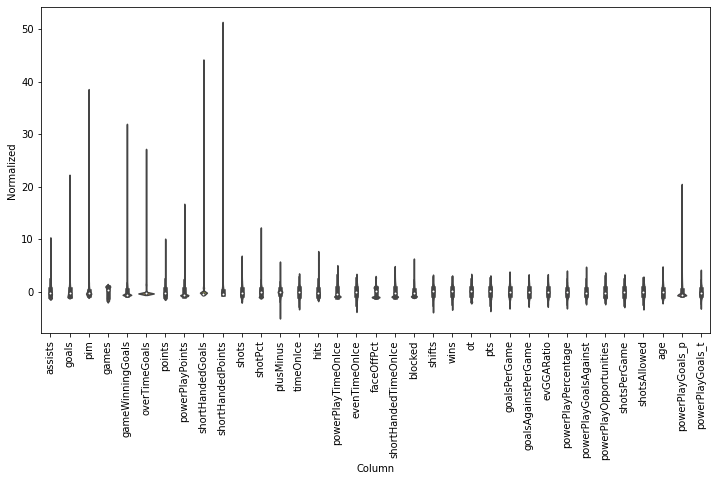

In [31]:
# Plot normalized features to check for outliers.
norm = (df_train[feature_col] - feature_mean) / feature_std
norm = norm.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data=norm)
_ = ax.set_xticklabels(feature_col, rotation=90)

#### Slice windows

In [32]:
# Slice training and testing datasets.
# Use data from previous 3 seasons.
WINDOW = 3
train_features, train_targets, train_naive = \
    season_window(df_train, WINDOW, feature_col, target_col)
test_features, test_targets, test_naive = \
    season_window(df_test, WINDOW, feature_col, target_col)

In [33]:
# Normalize the windowed data with mean and standard deviation
# of data in the original training dataframe.
train_features = (train_features - feature_mean) / feature_std
test_features = (test_features - feature_mean) / feature_std
train_targets = (train_targets - target_mean) / target_std
test_targets = (test_targets - target_mean) / target_std
train_naive = (train_naive - target_mean) / target_std
test_naive = (test_naive - target_mean) / target_std

In [34]:
ds_train = tf.data.Dataset.from_tensor_slices((
    train_features, train_targets))
ds_test = tf.data.Dataset.from_tensor_slices((
    test_features, test_targets))

In [35]:
BUFFER = 10000
BATCH = 256
ds_test = ds_test.shuffle(BUFFER).batch(BATCH).prefetch(1)
ds_train = ds_train.shuffle(BUFFER).batch(BATCH).prefetch(1)

#### Model and training
Flatten the previous seasons' data.

In [36]:
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(3)
])

In [37]:
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate = 0.001),
    loss = "mean_squared_error",
    metrics = [tfa.metrics.r_square.RSquare(y_shape = (len(target_col),))])

In [38]:
history = model.fit(ds_train, validation_data = ds_test,
                    epochs = 500, verbose = 0)

In [39]:
model.evaluate(ds_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.3650 - r_square: 0.6842


[0.3650338053703308, 0.6841914057731628]

In [40]:
# naive model metrics
print("loss", keras.metrics.mse(test_targets, test_naive).numpy().mean())
metric = tfa.metrics.r_square.RSquare(y_shape = (3,))
metric.update_state(test_targets, test_naive)
print("r_square:", metric.result().numpy())

loss 0.4582955640003411
r_square: 0.6035545


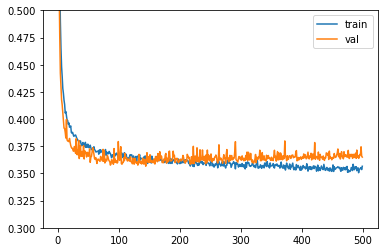

In [41]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "val")
plt.ylim(0.3, 0.5)
plt.legend()

#### Predict season 20192020 for evaluation.

In [42]:
pred_season = "20192020"
df.reset_index(drop = True, inplace = True)
pred_f, rids = pred_season_window(df, WINDOW, feature_col, pred_season)

In [43]:
pred_f = (pred_f - feature_mean) / feature_std

In [44]:
pred_y = model.predict(pred_f)
pred_y = pred_y * target_std + target_mean
pred = pd.DataFrame(pred_y, columns = target_col)

In [45]:
id_true = (df.loc[rids,
                  target_col + ["playerId", "gamesPlayed", "points", "games"]]
           .reset_index(drop = True))
pred = pred.merge(id_true, how = "left",
                  left_index = True, right_index = True,
                  suffixes = ['', '_true'])
pred["pred_points"] = np.round((pred["assists_total"] + 
                          pred["goals_total"]) * pred["gamesPlayed"])
pred["true_points"] = pred["points"] * pred["games"] * pred["gamesPlayed"]
pred["true_points"] = pred["true_points"].astype(int)
pred["pred_points"] = pred["pred_points"].astype(int)

In [46]:
# Check the top 5 players.
(pred.merge(
    (players[["playerId", "playerName"]]
     .drop_duplicates()
     .set_index("playerId")),
    how = "left",
    left_on = ["playerId"],
    right_index = True
).sort_values("pred_points", ascending=False)
.head())

,assists_total,goals_total,shots_total,assists_total_true,goals_total_true,shots_total_true,playerId,gamesPlayed,points,games,pred_points,true_points,playerName
596,0.826447,0.447893,3.240997,0.887324,0.478873,2.985915,8478402,71,1.515625,0.901408,90,97,Connor McDavid
491,0.694475,0.453011,3.742840,0.816901,0.492958,4.478873,8477492,71,1.347826,0.971831,81,93,Nathan MacKinnon
339,0.704222,0.402314,2.911519,0.732394,0.464789,2.957746,8476453,71,1.250000,0.957746,79,85,Nikita Kucherov
77,0.702413,0.400738,2.701947,0.830986,0.394366,2.605634,8473419,71,1.242857,0.985915,78,87,Brad Marchand
122,0.681163,0.409623,3.408235,0.718310,0.464789,3.873239,8474141,71,1.200000,0.985915,77,84,Patrick Kane


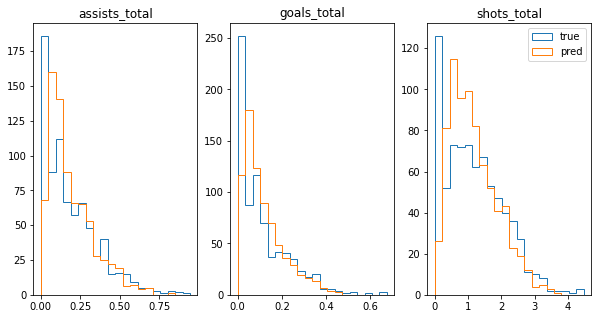

In [47]:
# Plot distribution of prediction and true values.
f = plt.figure(figsize = (10, 5))
for i, t in enumerate(target_col):
    plt.subplot(1, len(target_col), i + 1)
    n, bins, _ = plt.hist(df.loc[rids, t], 
                   bins = 20, histtype = "step", label = "true")
    plt.hist(pred[t], bins = bins, histtype = "step", label = "pred")
    plt.title(t)
plt.legend()

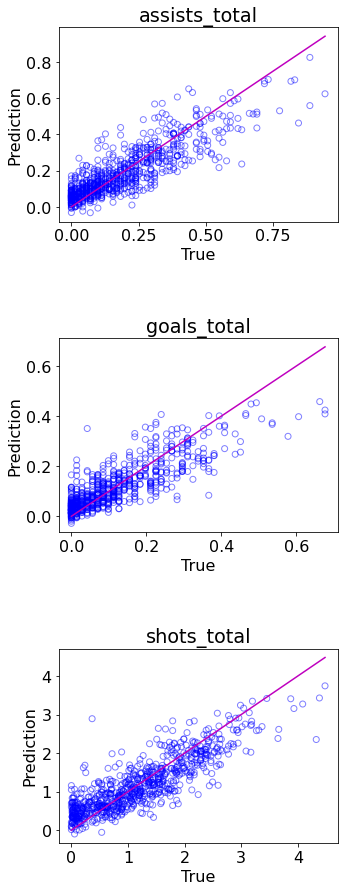

In [48]:
# Scatter plot prediction against true values.
f = plt.figure(figsize = (5, 15))
plt.rcParams.update({'font.size': 16})
plt.subplots_adjust(hspace = 0.6)
for i, t in enumerate(target_col):
    plt.subplot(len(target_col), 1, i + 1)
    limit = max(df.loc[rids, t].max(), pred[t].max())
    plt.plot([0, limit], [0, limit], c = 'm')
    ax = plt.scatter(df.loc[rids, t], pred[t], 
                     facecolors = 'none', edgecolors = 'b',
                     alpha = 0.5)
    plt.xlabel("True")
    plt.ylabel("Prediction")
    plt.title(t)

#### Predict next season

In [49]:
pred_year = 2021
df.reset_index(drop = True, inplace = True)
pred_f, rids = pred_new_window(df, WINDOW, feature_col, pred_year)

In [50]:
pred_f = (pred_f - feature_mean) / feature_std

In [51]:
TOTAL_GAMES = 82
pred_y = model.predict(pred_f)
pred_y = pred_y * target_std + target_mean
pred_y *= TOTAL_GAMES
pred = pd.DataFrame(pred_y.astype(int), columns = target_col)

In [52]:
pred_ids = (df.loc[rids, "playerId"]
            .reset_index(drop = True))
pred = pred.merge(pred_ids, how = "left",
                  left_index = True, right_index = True)
pred["pred_points"] = pred["assists_total"] + pred["goals_total"]

In [53]:
# Include player and team information in the the prediction result.
skater_pred = \
(pred.merge(
    (players.loc[players["season"] == "20202021",
                 ["playerId", "playerName", "teamId", "teamName"]]
     .drop_duplicates()
     .set_index("playerId")),
    how = "left",
    left_on = ["playerId"],
    right_index = True
).merge(
    (player_stats[["id", "position"]]
     .set_index("id")),
    how = "left",
    left_on = ["playerId"],
    right_index = True
)
.sort_values("pred_points", ascending=False))
skater_pred.head()

,assists_total,goals_total,shots_total,playerId,pred_points,playerName,teamId,teamName,position
546,77,42,294,8478402,119,Connor McDavid,22,Edmonton Oilers,C
474,62,39,253,8477934,101,Leon Draisaitl,22,Edmonton Oilers,C
435,60,37,309,8477492,97,Nathan MacKinnon,21,Colorado Avalanche,C
642,46,44,331,8479318,90,Auston Matthews,10,Toronto Maple Leafs,C
588,61,29,231,8478483,90,Mitchell Marner,10,Toronto Maple Leafs,R


In [54]:
# Save to a csv file as result.
skater_pred.to_csv("skater_pred.csv")

### Goalies

#### Prepare data for training

In [55]:
# Add team seasonal stats
# If a player is in multiple team for a season, average the team stats
player_team_seasonal = \
    (players[["playerId", "season", "teamId"]].merge(
        team_seasonal_norm.set_index(["teamId", "season"]),
        how = "left",
        left_on = ["teamId", "season"],
        right_index = True)
    .groupby(["playerId", "season"])
    .agg("mean"))

In [56]:
goalie_norm_t = goalie_norm.copy()
goalie_norm_t = goalie_norm_t.merge(
    player_team_seasonal,
    how = "left",
    left_on = ["playerId", "season"],
    right_index = True,
    suffixes = ['_p', '_t'])

In [57]:
# Add total number of assists, goals and shots to data
# normalize by season total number of games
target_f = ["wins", "saves", "goalsAgainst"]
for t in target_f:
    goalie_norm_t[t + "_total"] = \
        goalie_seasonal[t] / goalie_norm_t["gamesPlayed"]

In [58]:
# Add player age column
goalie_norm_t = goalie_norm_t.merge(
    player_stats[["id", "birthYear"]].set_index("id"),
    how = "left",
    left_on = ["playerId"],
    right_index = True
)
goalie_norm_t["age"] = goalie_norm_t["year"] - goalie_norm_t["birthYear"]

In [59]:
# Normalize games played by team games
goalie_norm_t["games"] /= goalie_norm_t["gamesPlayed"]

In [60]:
goalie_norm_t.sort_values(["playerId", "year"],
                          kind = "mergesort", 
                          inplace = True)

In [61]:
not_feature_col = \
    (["playerId", "season", "year", "gamesPlayed", "losses_p"] 
     + goalie_norm_t.columns[goalie_norm_t.count() < 4000].to_list()
     + ['shotsAllowed','winScoreFirst', 'winOppScoreFirst',
        'winLeadFirstPer', 'winLeadSecondPer', 'winOutshootOpp',
        'winOutshotByOpp','faceOffsTaken','faceOffWinPercentage',
        'shootingPctg', 'savePctg', 'losses_t'])             
feature_col = \
    goalie_norm_t.columns.drop(not_feature_col).to_list()
target_col = [x + "_total" for x in target_f]
df = goalie_norm_t.dropna(subset = feature_col)

#### Split training and test set and normalize

In [62]:
# Split training and testing dataset by players
TEST = 0.2

pids = np.unique(df["playerId"])
np.random.seed(131)
np.random.shuffle(pids)
dft = df.set_index("playerId")
sep = int(len(pids) * TEST)
df_train = dft.loc[pids[sep:]].reset_index()
df_test = dft.loc[pids[:sep]].reset_index()

In [63]:
dft = df.set_index("playerId")
sep = int(len(pids) * TEST)
df_train = dft.loc[pids[sep:]].reset_index()
df_test = dft.loc[pids[:sep]].reset_index()

In [64]:
# Calculate mean and std from training set for normlization
feature_mean = df_train[feature_col].to_numpy().mean(axis = 0)
feature_std = df_train[feature_col].to_numpy().std(axis = 0)
target_mean = df_train[target_col].to_numpy().mean(axis = 0)
target_std = df_train[target_col].to_numpy().std(axis = 0)

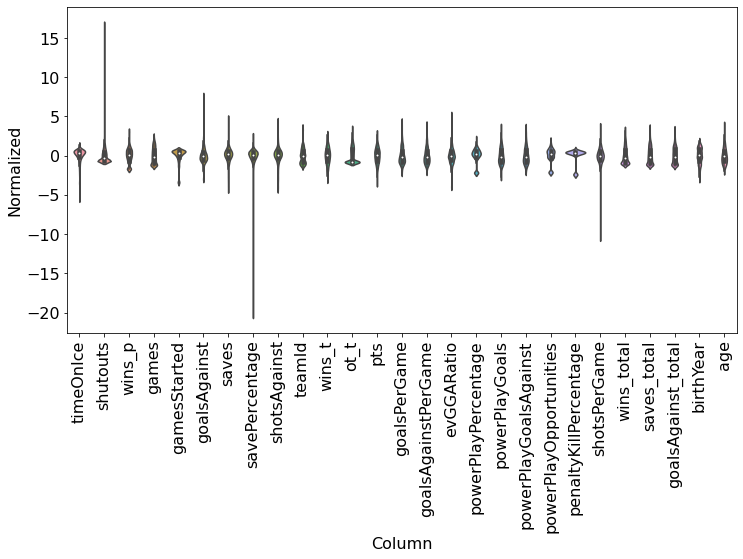

In [65]:
norm = (df_train[feature_col] - feature_mean) / feature_std
norm = norm.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data=norm)
_ = ax.set_xticklabels(feature_col, rotation=90)

#### Slice windows

In [66]:
# Only consider the previous season.
WINDOW = 1
train_features, train_targets, train_naive = \
    season_window(df_train, WINDOW, feature_col, target_col)
test_features, test_targets, test_naive = \
    season_window(df_test, WINDOW, feature_col, target_col)

In [67]:
train_features = (train_features - feature_mean) / feature_std
test_features = (test_features - feature_mean) / feature_std
train_targets = (train_targets - target_mean) / target_std
test_targets = (test_targets - target_mean) / target_std
train_naive = (train_naive - target_mean) / target_std
test_naive = (test_naive - target_mean) / target_std

In [68]:
ds_train = tf.data.Dataset.from_tensor_slices((
    train_features, train_targets))
ds_test = tf.data.Dataset.from_tensor_slices((
    test_features, test_targets))

In [69]:
BUFFER = 10000
BATCH = 256
ds_test = ds_test.shuffle(BUFFER).batch(BATCH).prefetch(1)
ds_train = ds_train.shuffle(BUFFER).batch(BATCH).prefetch(1)

#### Model and training

In [70]:
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(8, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3)
])

In [71]:
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate = 0.001),
    loss = "mse",
    metrics = [tfa.metrics.r_square.RSquare(y_shape = (len(target_col),))])

In [72]:
history = model.fit(ds_train, validation_data = ds_test,
                    epochs = 500, verbose = 0)

In [73]:
model.evaluate(ds_test)

3/3 [==============================] - 0s 4ms/step - loss: 0.5587 - r_square: 0.4593


[0.5587239265441895, 0.45925870537757874]

In [75]:
# naive model metrics
print("loss:", keras.metrics.mse(test_targets, test_naive).numpy().mean())
metric = tfa.metrics.r_square.RSquare(y_shape = (3,))
metric.update_state(test_targets, test_naive)
print("r_square:", metric.result().numpy())

loss: 0.7375579392859581
r_square: 0.2814859


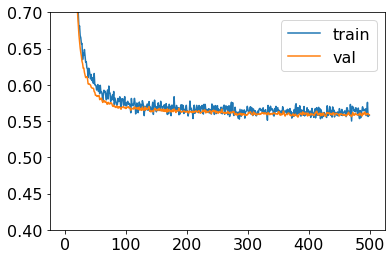

In [76]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "val")
plt.ylim(0.4, 0.7)
plt.legend()

#### Predict season 20192020 for evaluation

In [77]:
pred_season = "20192020"
df.reset_index(drop = True, inplace = True)
pred_f, rids = pred_season_window(df, WINDOW, feature_col, pred_season)

In [78]:
pred_f = (pred_f - feature_mean) / feature_std

In [79]:
pred_y = model.predict(pred_f)
pred_y = pred_y * target_std + target_mean
pred = pd.DataFrame(pred_y, columns = target_col)

In [80]:
id_true = (df.loc[rids, target_col 
                  + ["playerId", "gamesPlayed"]]
           .reset_index(drop = True))
pred = pred.merge(id_true, how = "left",
                  left_index = True, right_index = True,
                  suffixes = ['', '_true'])
pred["pred_wins"] = np.round(pred["wins_total"] * pred["gamesPlayed"])
pred["true_wins"] = np.round(pred["wins_total_true"] * pred["gamesPlayed"])

In [81]:
(pred.merge(
    (players[["playerId", "playerName"]]
     .drop_duplicates()
     .set_index("playerId")),
    how = "left",
    left_on = ["playerId"],
    right_index = True
).sort_values("pred_wins", ascending=False)
.head())

,wins_total,saves_total,goalsAgainst_total,wins_total_true,saves_total_true,goalsAgainst_total_true,playerId,gamesPlayed,pred_wins,true_wins,playerName
47,0.391481,18.710829,1.766476,0.500000,21.028571,1.900000,8476883,70.0,27.0,35.0,Andrei Vasilevskiy
51,0.347896,18.993463,1.933667,0.436620,23.323944,1.971831,8476945,71.0,25.0,31.0,Connor Hellebuyck
15,0.342416,17.275301,1.639633,0.380282,22.464789,2.253521,8471679,71.0,24.0,27.0,Carey Price
31,0.323101,17.639093,1.657037,0.228571,11.971429,0.928571,8475311,70.0,23.0,16.0,Darcy Kuemper
34,0.334835,17.106086,1.619934,0.333333,19.623188,2.188406,8475683,69.0,23.0,23.0,Sergei Bobrovsky


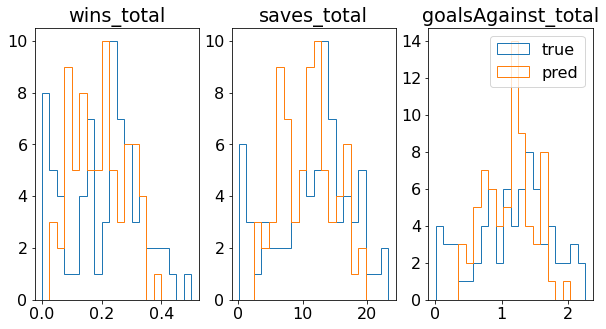

In [82]:
# Plot distribution of prediction and true values.
f = plt.figure(figsize = (10, 5))
for i, t in enumerate(target_col):
    plt.subplot(1, len(target_col), i + 1)
    n, bins, _ = plt.hist(df.loc[rids, t], 
                   bins = 20, histtype = "step", label = "true")
    plt.hist(pred[t], bins = bins, histtype = "step", label = "pred")
    plt.title(t)
plt.legend()

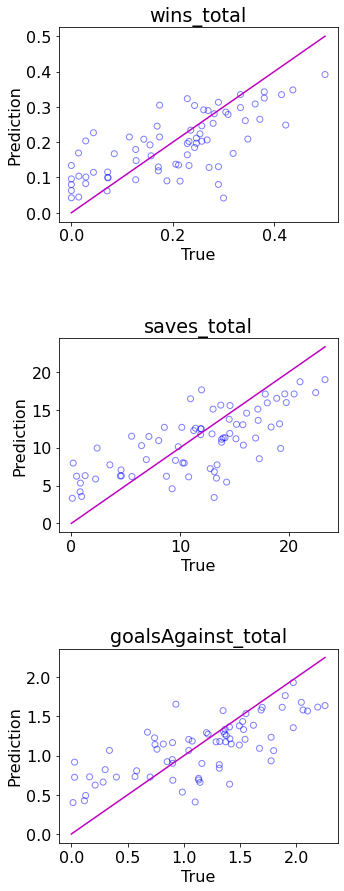

In [83]:
f = plt.figure(figsize = (5, 15))
plt.rcParams.update({'font.size': 16})
plt.subplots_adjust(hspace = 0.6)
for i, t in enumerate(target_col):
    plt.subplot(len(target_col), 1, i + 1)
    limit = max(df.loc[rids, t].max(), pred[t].max())
    plt.plot([0, limit], [0, limit], c = 'm')
    ax = plt.scatter(df.loc[rids, t], pred[t], 
                     facecolors = 'none', edgecolors = 'b',
                     alpha = 0.5)
    plt.xlabel("True")
    plt.ylabel("Prediction")
    plt.title(t)

#### Predict next season.

In [84]:
pred_year = 2021
df.reset_index(drop = True, inplace = True)
pred_f, rids = pred_new_window(df, WINDOW, feature_col, pred_year)

In [85]:
pred_f = (pred_f - feature_mean) / feature_std

In [86]:
TOTAL_GAMES = 82
pred_y = model.predict(pred_f)
pred_y = pred_y * target_std + target_mean
pred_y *= TOTAL_GAMES
pred = pd.DataFrame(pred_y.astype(int), columns = target_col)

In [87]:
pred_ids = (df.loc[rids, "playerId"]
            .reset_index(drop = True))
pred = pred.merge(pred_ids, how = "left",
                  left_index = True, right_index = True)

In [88]:
# Include player and team information in the the prediction result.
goalie_pred = \
(pred.merge(
    (players.loc[players["season"] == "20202021",
                 ["playerId", "playerName", "teamId", "teamName"]]
     .drop_duplicates()
     .set_index("playerId")),
    how = "left",
    left_on = ["playerId"],
    right_index = True
).merge(
    (player_stats[["id", "position"]]
     .set_index("id")),
    how = "left",
    left_on = ["playerId"],
    right_index = True
)
.sort_values("wins_total", ascending=False))
goalie_pred.head()

,wins_total,saves_total,goalsAgainst_total,playerId,playerName,teamId,teamName,position
46,32,1570,142,8476883,Andrei Vasilevskiy,14,Tampa Bay Lightning,G
32,31,1432,129,8475831,Philipp Grubauer,21,Colorado Avalanche,G
4,28,1425,130,8470594,Marc-Andre Fleury,54,Vegas Golden Knights,G
51,28,1551,152,8476945,Connor Hellebuyck,52,Winnipeg Jets,G
58,26,1362,127,8477424,Juuse Saros,18,Nashville Predators,G


In [89]:
# Save to drive.
goalie_pred.to_csv("goalie_pred.csv")